### Загрузка библиотек

In [1]:
from IPython.display import Markdown as md
from pathlib import Path
from shutil import unpack_archive
import numpy as np
import pandas as pd
from itertools import product
import matplotlib
matplotlib.rcParams['font.family'] = 'Segoe UI'
import matplotlib.pyplot as plt
%matplotlib inline
import functions as f
from kaggle import Kaggle

### Основные настройки

In [2]:
COMPETITION = 'skillbox-recommender-system'            # Название соревнования на платформе Kaggle
PROJECT_PATH = Path('D:/skillbox-recommender-system')  # Путь к папке проекта
DATA_PATH = PROJECT_PATH / 'data'                      # Путь к папке данных
TRANSACTIONS_PATH = DATA_PATH / 'transactions.csv'     # Путь к файлу логов транзакций
PRODUCTS_PATH = DATA_PATH / 'products.csv'             # Путь к файлу справочника продуктов
EVAL_PATH = PROJECT_PATH / 'eval'                      # Путь к папке с предсказаниями
WORKERS = 4                                            # Количество процессов параллельных вычислений

### Вспомогательные функции

In [3]:
def multiprocessing(workers:int =WORKERS, data_path=DATA_PATH,
                    start: float = 0.0, stop: float = 1.0, num: int = 11,
                    func: str ='get_map10_by_rates', 
                    days_rate: float = 0.0, cart_rate: float = 0.0):
    '''
    Запускает скрипт параллельных вычислений multiproc.py с требуемыми параметрами.
    
    Аргументы:
    workers - количество параллельных процессов
    data_path - путь к папке данных
    func - выполняемая функция (см. multiproc.py)
    start, stop, num - начальное значение аргумента
    days_rate - коэффициент фильтрации по времени покупки
    cart_rate - коэффициент фильтрации по номеру добавления продукта в корзину
    '''

    %run -t multiproc \
        --workers={workers} --data_path={data_path} \
        --start={start} --stop={stop} --num={num} \
        --func={func} --days_rate={days_rate} --cart_rate={cart_rate}
    
    with open(DATA_PATH / 'precisions.dmp', 'rb') as fp:
        map10 = load(fp)
    
    return map10

### Загрузка данных

In [4]:
kaggle = Kaggle(COMPETITION, verbose=1)

In [5]:
if not PROJECT_PATH.exists():
    PROJECT_PATH.mkdir()
    
if not DATA_PATH.exists():
    DATA_PATH.mkdir()

#### Журнал транзакций

**Журнал транзакций** содержит следующие поля:
- `order_id` - уникальный идентификатор транзакции
- `user_id` - уникальный идентификатор покупателя
- `order_number` - номер транзакции в истории покупок данного пользователя
- `order_dow` - день недели транзакции
- `order_hour_of_day` - час совершения транзакции
- `days_since_prior_order` - количество дней с совершения предыдущей транзакции данным пользователем
- `product_id` - уникальный идентификатор продукта
- `add_to_cart_order` - номер, под которым данный продукт был добавлен в корзину
- `reordered` - был ли продукт "перезаказан"

В связи с тем, что по заданию мы не знаем, когда (через сколько дней после последней покупки) 
и в какое время пользователи будут совершать очередные покупки, то такая информация как день недели (поле `order_dow`) и время совершения покупок (`order_hour_of_day`) нам врядли чем-то поможет, поэтому имеет смысл исключить её из набора данных.
Также вряд ли чем-то может помочь информация об идентификаторе транзакции (`order_id`) и перезаказе продуктов (`reordered`).

In [6]:
file_path = TRANSACTIONS_PATH.with_suffix('.dmp')
if not file_path.exists():
    if not TRANSACTIONS_PATH.with_suffix('.csv.zip').exists():
        kaggle.download_data_files([TRANSACTIONS_PATH.name], DATA_PATH)
    if TRANSACTIONS_PATH.with_suffix('.csv.zip').exists():
        unpack_archive(TRANSACTIONS_PATH.with_suffix('.csv.zip'), DATA_PATH)
        transactions = pd.read_csv(TRANSACTIONS_PATH, usecols=['user_id', 'order_number', 'days_since_prior_order', 
                                                               'product_id', 'add_to_cart_order'])
        
        with open(file_path, 'wb') as fp:
            dump(transactions, fp)
else:
    with open(file_path, 'rb') as fp:
        transactions = load(fp)

#### Cправочник продуктов

**Cправочник продуктов** содержит следующие поля:
- `product_id` - уникальный идентификатор товара
- `product_name` - название товара
- `aisle_id` - уникальный идентификатор подкатегории
- `department_id` - уникальный идентификатор категории
- `aisle` - название подкатегории
- `department` - название категории

In [7]:
file_path = PRODUCTS_PATH.with_suffix('.dmp')
if not file_path.exists():
    if not PRODUCTS_PATH.with_suffix('.csv.zip').exists():
        kaggle.download_data_files([PRODUCTS_PATH.name], DATA_PATH)
    if PRODUCTS_PATH.with_suffix('.csv.zip').exists():
        unpack_archive(PRODUCTS_PATH.with_suffix('.csv.zip'), DATA_PATH)
    products = pd.read_csv(PRODUCTS_PATH)
    with open(file_path, 'wb') as fp:
        dump(products, fp)
else:
    with open(file_path, 'rb') as fp:
        products = load(fp)    

### Гипотеза для разработки модели

Магазин продает продукты питания. Важной спецификой продаж продуктов питания является то, что люди как правило покупают примерно одни и теже продукты. Конечно, иногда предпочтения покупателей меняются, они пробуют новые продукты. Но изменения продуктовых предпочтений происходят планомерно. Т.е. основной набор продуктов достаточно стабилен. Конечно в жизни людей периодически происходят различные события
(дни рождения, визиты гостей, путешествия и т.п.), которые влияют на покупаемый ими продуктовый набор. Но у большинства людей эти события происходят не так часто. Поэтому предположим, что выделив набор продуктов, которые пользователь наиболее часто покупал, особенно в последнее время, можно понять какие продукты следует ему предложить к покупке.

Кроме того следует обрабатить внимание на порядок добавления продуктов в корзину. Этот признак может косвенно указывать на важность того или иного продукта для пользователя. Ведь сначала мы как правило самые важные для нас продукты. 

### Предобработка данных

В соответствии с выдвинутой гипозей для предсказания покупок необходимо учитывать историю покупок продуктов. Для этого нужна временная метка совершения покупок. Но в исходных данных имеется информация только о количестве дней между покупками (`days_since_prior_oder`). Поэтому мы не можем построить абсолютную временную шкалу покупок, а только относительную. Т.к. в соответствии с концепцией важно знать насколько давно относительно планируемой совершались остальные покупки, то временную шкалу следует отсчитывать от последней известной покупки. Для этого в журнал транзакций добавим призак, который будет показывать количество дней от каждой покупки пользователя до его последней покупки (`days_before_last_order`). И далее под "**временем**" заказа **будем подразумевать** как раз **значение значение этого признака**.

Дополнительно будем считать одним заказом, сделанные в один день заказы. Продукты, присутствующие в них объединим, а порядок добавления в корзину сделаем сквозным. Будем считать, что пользователь сначала в корзину добавил заказы из первого заказа, а потом из второго и т.д.

После обработки **журнал транзакций** будет иметь следующие поля:
- `user_id` - уникальный идентификатор покупателя
- `days_before_last_order` - количество дней с совершения предыдущей транзакции данным пользователем
- `product_id` - уникальный идентификатор продукта
- `add_to_cart_order` - номер, под которым данный продукт был добавлен в корзину

Модель будем обучать на всех транзакциях пользователей, кроме последних. А качество ее работы будем проверять как раз на последних транзакциях. Поэтому сразу разделим журнал транзакций на две части:
- последние транзакции, на которых мы будем оценивать качество предсказаний (`last_transactions`)
- предыдущие транзакции, на основе которых мы будем формировать предсказания модели (`prior_transactions`).

Кроме того для оценки точности предсказаний модели при валидации потребуется список продуктов в последних покупках (`last_products`).

In [8]:
file_paths = [DATA_PATH / file_name 
              for file_name in ['prior_transactions.dmp', 'last_transactions.dmp', 'last_products.dmp']]
if any(not file_path.exists() for file_path in file_paths):
        prior_transactions, last_transactions, last_products = f.preprocess_transactions(transactions)
        del transactions
        file_path = DATA_PATH / 'prior_transactions.dmp'
        with open(file_path, 'wb') as fp:
            dump(prior_transactions, fp)
        file_path = DATA_PATH / 'last_transactions.dmp'
        with open(file_path, 'wb') as fp:
            dump(last_transactions, fp)
        file_path = DATA_PATH / 'last_products.dmp'
        with open(file_path, 'wb') as fp:
            dump(last_products, fp)
else:
        file_path = DATA_PATH / 'prior_transactions.dmp'
        with open(file_path, 'rb') as fp:
            prior_transactions = load(fp)
        file_path = DATA_PATH / 'last_transactions.dmp'
        with open(file_path, 'rb') as fp:
            last_transactions = load(fp)
        file_path = DATA_PATH / 'last_products.dmp'
        with open(file_path, 'rb') as fp:
            last_products = load(fp)    

### Статический анализ данных

Для подтверждения гипотезы проведем статический анализ данных. Первым делом выясним какая часть продуктов из последнего заказа пользователей покупалась ими ранее.

Для этого для каждого продукта последнего заказа каждого пользователя, найдем заказы этого пользователя, в которых он ранее встречался.

In [9]:
products_reordering = prior_transactions\
    .merge(last_transactions[['user_id', 'product_id']], on=['user_id', 'product_id'], how='right')
products_reordering['days_before_last_order'] += products_reordering['days_before_last_order_shift']

In [10]:
prior_ordered_fraq = products_reordering['days_before_last_order'].count() / products_reordering['days_before_last_order'].shape[0] * 100

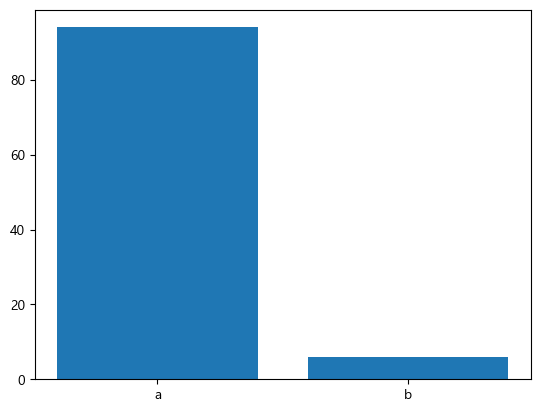

In [11]:
fig, ax = plt.subplots()
_ = ax.bar(x=['a', 'b'], height=[prior_ordered_fraq, 100 - prior_ordered_fraq])

Затем для каждого пользователя найдем процент продуктов из последнего заказа, которые он уже покупал ранее, и отобразим распределение этой величины с помощью гистораммы.

In [12]:
products_reordering_percentages = products_reordering.groupby('user_id')\
    .count().rename(columns={'product_id': 'products_total', 'days_before_last_order': 'reordered_products'})
products_reordering_percentages['reordered_percentage'] = \
    products_reordering_percentages['reordered_products'] / products_reordering_percentages['products_total'] * 100

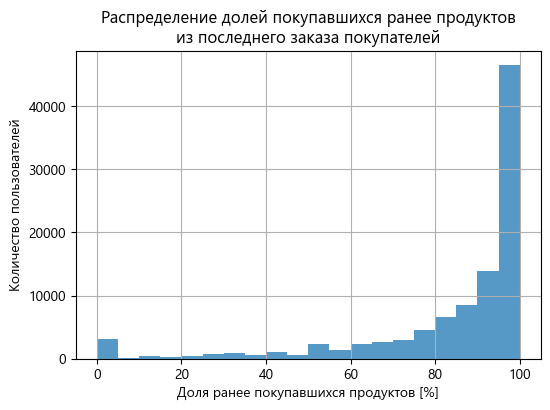

In [13]:
ax = products_reordering_percentages['reordered_percentage'].plot(
    kind='hist', bins=20,
    title='Распределение долей покупавшихся ранее продуктов\nиз последнего заказа покупателей',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.set_xlabel('Доля ранее покупавшихся продуктов [%]')
_ = ax.set_ylabel('Количество пользователей')

Гистограмма однозначно показывает, что подавляющее большинство продуктов в последнем заказе пользователей ранее уже ими заказывались. Т.е. предположение, что пользователи в основном покупают продукты, которые покупали ранее, подтвердилось.

Теперь проверим предположение о том, что продуктовые предпочтения пользователей со временем могут меняться, и что нужно учитывать этот фактор. Для этого построим график доли продуктов в заказах пользователей, которые присутствуют в их последних заказах, в зависимости от времени заказа с интервалом в 1 месяц.

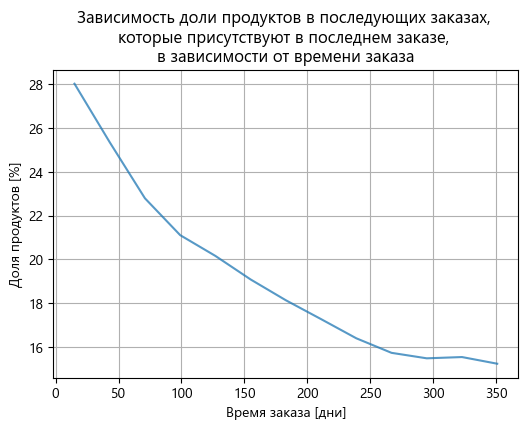

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
x = prior_transactions['days_before_last_order'] + prior_transactions['days_before_last_order_shift']
nbins = int(np.ceil((x.max() - x.min()) / 30))
total_counts, bins, _ = ax.hist(x, bins=nbins)
ax.clear()
x = products_reordering['days_before_last_order']
reordered_counts, _, _ = ax.hist(x, bins=nbins)
ax.clear()
x = [(x1 + x2) / 2 for x1, x2 in zip(bins[:-1], bins[1:])]
y = [reordered_count / total_count * 100 for total_count, reordered_count in zip(total_counts, reordered_counts)]
line, = ax.plot(x, y)
line.set_alpha(0.75)
ax.set_title('Зависимость доли продуктов в последующих заказах, '
              '\nкоторые присутствуют в последнем заказе, '
              '\nв зависимости от времени заказа')
ax.set_xlabel('Время заказа [дни]')
ax.set_ylabel('Доля продуктов [%]')
ax.grid()

График однозначно **показывает**, что действительно наблюдается тенденция к тому, что **предпочтения пользователей со временем меняются**. Так доля продуктов, которые были заказаны за **месяц** до последнего заказа и присутствуют в последнем заказе, составляет **28%**. А вот доля присутствия в последнем заказе продуктов, купленных почти **год** назад, почти в два раза меньше - около **15%**.

Далее проверим ещё одно предположение о том, что порядковый номер добавления продукта в корзину отражает его важность для пользователя, и что этот признак можно использовать при формировании предсказаний. Для этого построим график доли продуктов в заказах пользователей, которые присутствуют в их последнем заказе, в зависимости от порядкового номера продуктов в корзину.

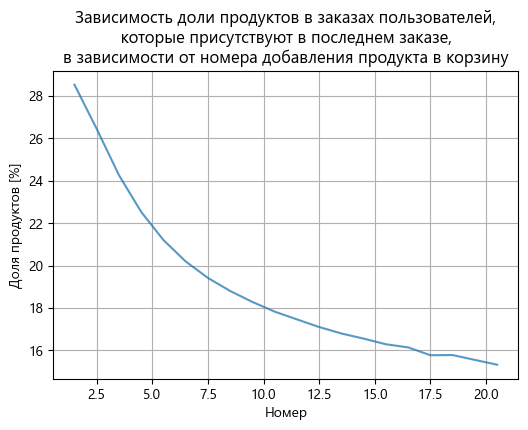

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
x = prior_transactions['add_to_cart_order']
nbins = int(x.max() - x.min())
total_density, bins, _ = ax.hist(x, bins=nbins, density=True)
add_to_cart_max = sum(total_density >= 0.01)
bins = bins[:add_to_cart_max + 1]
ax.clear()
total_counts, _, _ = ax.hist(x, bins=nbins)
total_counts = total_counts[:add_to_cart_max]
ax.clear()
x = products_reordering['add_to_cart_order']
reordered_counts, _, _ = ax.hist(x, bins=nbins)
reordered_counts = reordered_counts[:add_to_cart_max]
ax.clear()
x = [(x1 + x2) / 2 for x1, x2 in zip(bins[:-1], bins[1:])]
y = [reordered_count / total_count * 100 for total_count, reordered_count in zip(total_counts, reordered_counts)]
line, = ax.plot(x, y)
line.set_alpha(0.75)
ax.set_title('Зависимость доли продуктов в заказах пользователей,\n '
             'которые присутствуют в последнем заказе, \n'
             'в зависимости от номера добавления продукта в корзину')
ax.set_xlabel('Номер')
ax.set_ylabel('Доля продуктов [%]')
ax.grid()

График однозначно показывает, что действительно продукты из последнего заказа, в предшествующих заказах часто добавлялись в корзину одними из первых. Так доля продуктов, которые были **добавлены в корзину первыми** и присутствуют в последнем заказе, составляет около **28,5%**. А вот доля присутствия в последнем заказе продуктов, и добавленных в корзину **21-ми** почти в два раза меньше - около **15,5%**. Так что **следует учитывать этот признак** в модели.

### Создание модели рекомендаций

#### Фильтрация по частоте покупок продуктов

В соответствии с выбранной концепцией модели предсказаний рейтинг продуктов для каждого пользователя нужно в первую очередь оценивать по частоте его покупок данным пользователем. В этом случае у продуктов, которые пользователь ни разу не покупал будет нулевой рейтинг. А у продуктов, которые пользователь покупал, рейтинг будет равен количеству покупок этого продукта. Такой тип фильтрации можно описать следующей формулой:
$$r_{u,i}=\sum_{t \in T_u}s_{u,i,t},$$
где&nbsp;$r_{u,i}$ - рейтинг продукта с номером $i$ у пользователя с номером $u$ ($i \in I$, где $I$ - множество номеров продуктов; $u \in U$, где $U$ - множество номеров пользователей);  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$T_u$ - номера транзакций, совершенных пользователем с номером $u$ ($T_u \in T$, где $T$ - множество номеров транзакций);  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s_{u,i,t}$ - присутствие продукта с номером $i$ в транзакции с номером $t$ пользователя с номером $u$: $0$-нет, $1$-да.

Посмотрим какую точность по метрике $MAP@10$ имеют предсказания на основе такого алгоритма.

In [16]:
frequency_weights = f.get_weights(prior_transactions)
frequency_ratings = f.get_ratings(frequency_weights)
frequency_prediction = f.get_prediction(frequency_ratings)
frequency_map_10 = f.get_prediction_precision(true=last_products, prediction=frequency_prediction)

(0.0, 20.0)

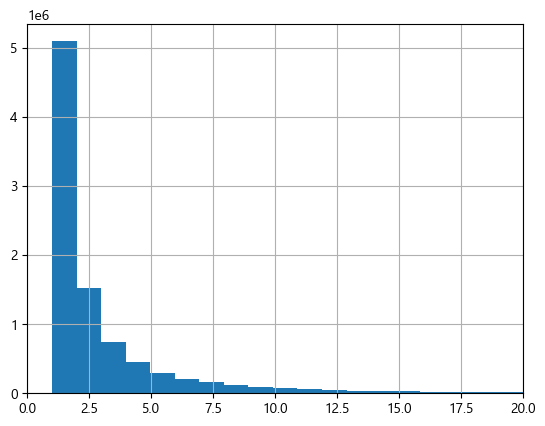

In [17]:
ax = frequency_ratings['rating'].hist(bins=frequency_ratings['rating'].max())
ax.set_xlim(0, 20)

In [18]:
md(f'Значение метрики $MAP@10$ в этом случае равно **{frequency_map_10:.6f}**. '
   f'Это уже приемлемый результат. Постраемся его улушить с помощью дополнительных фильтраций.')

Значение метрики $MAP@10$ в этом случае равно **0.280609**. Это уже приемлемый результат. Постраемся его улушить с помощью дополнительных фильтраций.

#### Фильтрация по времени покупки

В результате разведочного анализа мы подтвердили наличие зависимости доли купленных продуктов, попадающих в очередной заказ, от времени совершения заказа. В связи с этим следует снижать значимость заказов по мере их отдаления по времени от последнего заказа. Для этого введем понятие "**веса**" транзакции, который будет зависеть от времени её совершения. По внешнему виду графика вышеуказанной зависимости, можно предположить, что она носит экспоненциальный характер. Поэтому и веса транзакций будем снижать по экспоненте, т.е. применим т.н. экспоненциальную фильтрацию, при которой веса транзаций определяются формулой:
$$w_{u,t}=e^{-d_{u,t}·a_d},$$
где&nbsp;$w_{u,t}$ - вес транзакции с номером $t$ пользователя с номером $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$d_{u,t}$ - время совершения транзакции с номером $t$ пользователя с номером $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$a_d$ - коэффициент фильтрации (положительное число).

При этом формула расчета рейтингов продуктов примет следующий вид:
$$r_{u,i}=\sum_{t \in T_u}s_{u,i,t}·w_{u,t}=\sum_{t \in T_u}s_{u,i,t}·e^{-d_{u,t}·a_d}.$$

Для проверки действия фильтрации по времени покупки и влияния значения коэффициента $a_d$ на точность предсказаний с её использованием построим график зависимости значения метрики $MAP@10$ от величины этого коэффициента.

In [19]:
start, stop, num = 0.0, 0.1, 21
map10_days = multiprocessing(start=start, stop=stop, num=num, func='get_map10_by_days_rates')


IPython CPU timings (estimated):
  User   :     114.12 s.
  System :       0.00 s.
Wall time:     114.13 s.


<Figure size 640x480 with 0 Axes>

In [20]:
map10_days_pred, days_rate = f.approximate_precision_by_rate(map10_days.index, map10_days, 7)
days_weights = f.get_weights(prior_transactions, days_rate=days_rate)
days_ratings = f.get_ratings(days_weights)
days_prediction = f.get_prediction(days_ratings)
days_map10 = f.get_prediction_precision(last_products, days_prediction)

(0.0, 20.0)

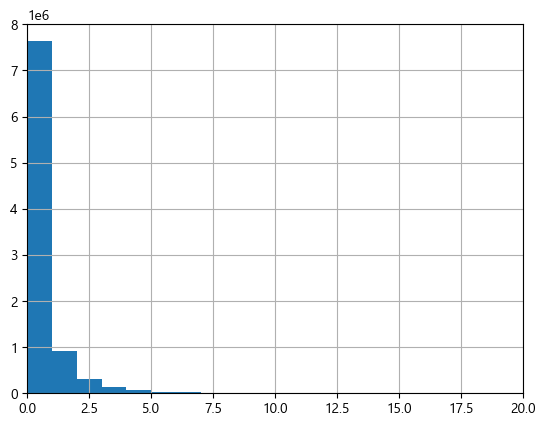

In [21]:
ax = days_ratings['rating'].hist(bins=int(np.ceil(days_ratings['rating']).max()))
ax.set_xlim(0, 20)

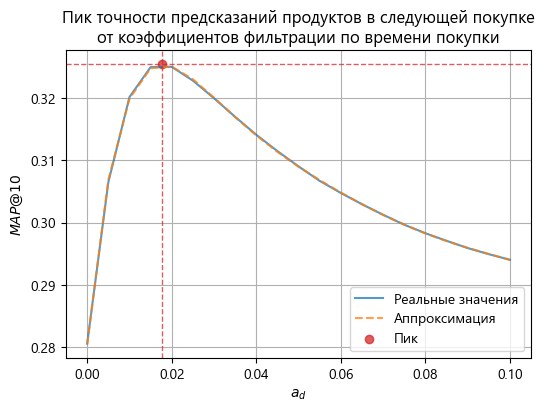

In [22]:
ax = map10_days.plot(
    title='Пик точности предсказаний продуктов в следующей покупке'
    '\nот коэффициентов фильтрации по времени покупки', 
    xlabel='$a_d$', ylabel='$MAP@10$',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.plot(map10_days.index.values, map10_days_pred, linestyle='--', color='#ff7f0e', alpha=0.75)
ax.scatter(days_rate, days_map10, color='#d62728', linewidth=1, alpha=0.75)
ax.axvline(days_rate, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
ax.axhline(days_map10, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
_ = ax.legend(['Реальные значения', 'Аппроксимация', 'Пик'])

График показывает, что значения коэффицента $a_d$ существенно влияет на качество фильтрации. При **значениях** этого коэффициента **близких к нулю**  (т.е. при слабой фильтрации), как и должно быть, **значение метрики $MAP@10$ близко к значению**, полученному только на основе **частоты покупок**. Далее **по мере роста коэффициента** наблюдается **быстрый рост** качества предсказаний, который **достигает** своего **пика** при значении коэффициента $a_d$ **в районе $0.015...0.02$**. При **продолжении роста** значения **коэффициента качество фильтраций** ожидаемо начинает **медленно снижаться** до исходного значения (метрика $MAP@10$ возвращается к значению, полученному только на основе частоты покупок).

Попробуем более точно определить положение и величину вершины пика этой зависимости. Для этого аппроксимируем функцию на $[0, 0.1]$ графика $MAP@10(a_d)$ с помощью полиномиальной функции 7-го порядка. После этого найдем точку на этом отрезке, в которой производная полиномиальной функции равна нулю. Это и будет искомая точка уточненного положения пика - оптимальное значение коэффицента $a_d$. А затем уже в той точке найдем реальное значение метрики $MAP@10$. Это значение будет характеризовать точность предсказаний при использовании фильтрации по времени.

In [24]:
md('**Результаты**:<br>'
   'Фильтрация по времени покупки дает **существенный прирост точности** предсказаний '
   f'(метрика $MAP@10$ **выросла** на **{(days_map10 - frequency_map_10):.6f}** с {frequency_map_10:.6f} до {days_map10:.6f}) '
   f'при значении коэффициента фильтрации $a_d$ равном **{days_rate:.6f}**.')

**Результаты**:<br>Фильтрация по времени покупки дает **существенный прирост точности** предсказаний (метрика $MAP@10$ **выросла** на **0.044813** с 0.280609 до 0.325421) при значении коэффициента фильтрации $a_d$ равном **0.017791**.

***Примечание***:  
*Безусловно можно было ещё повысить точность предсказаний на тренировочных данных, используя фильтрацию по времени для каждого пользователя в отдельности и даже для каждого продукта в отдельности. Но в этом случае у нашей модели очень сильно снизится обобщающая способность, т.е. модель станет сильно переобученной.*

#### Фильтрация по номеру добавления продукта в корзину

С помощью статистического анализа мы подтвердили наличие зависимости доли купленных продуктов, попадающих в очередной заказ, доли купленных продуктов, попадающих в очередной заказ, от номеров их добавления в. Попробуем учесть это обстоятельство и снижать вес продуктов с ростом порядкового номера добавления их в корзину. Так же как и в случае с фильтрацией по времени покупки будем использовать экспоненциальную фильтрацию. И так же будем использовать единый коэффициент для продуктов всех транзакций всех пользователей. В итоге у каждого продукта каждой транзакции каждого пользователя **появляется свой вес**, который описывается следующей формулой: 

$$w_{u,i,t} = e^{-d_{u,t}·a_d}·e^{-c_{u,i,t}·a_c}$$

где&nbsp;$w_{u,i,t}$ - вес продукта с номером $i$ в транзакции с номером $t$ пользователя с номером $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$d_{u,t}$ - время совершения транзакции с номером $t$ пользователя с номером $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$a_d$ - коэффициент фильтрации по времени покупки транзакций;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$c_{u,i,t}$ - порядковый номер добавления продукта с номером $i$ в корзину в транзакции с номером $t$ пользователя с номером $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$a_c$ - коэффициент фильтрации по номеру добавления продукта в корзину.

При добавлении данной фильтрации формула расчета рейтингов примет следующий вид:
$$r_{u,i}=\sum_{t \in T_u}s_{u,i,t}·w_{u,i,t} = \sum_{t \in T_u}s_{u,i,t}·e^{-d_{u,t}·a_d}·e^{-c_{u,i,t}·a_c}.$$

Для проверки действия фильтрации по порядковому номеру добавления продукта в корзину и влияния значения коэффициента $a_c$ на точность предсказаний с её использованием построим график зависимости значения метрики $MAP@10$ от величины этого коэффициента.

In [25]:
start, stop, num = 0.0, 0.05, 21
map10_cart = multiprocessing(start=start, stop=stop, num=num, func='get_map10_by_cart_rates', 
                             days_rate=days_rate)


IPython CPU timings (estimated):
  User   :     124.17 s.
  System :       0.00 s.
Wall time:     124.18 s.


<Figure size 640x480 with 0 Axes>

In [26]:
map10_cart_pred, cart_rate = f.approximate_precision_by_rate(map10_cart.index, map10_cart, 3)
cart_weights = f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate)
cart_ratings = f.get_ratings(cart_weights)
cart_prediction = f.get_prediction(cart_ratings)
cart_map10 = f.get_prediction_precision(last_products, cart_prediction)

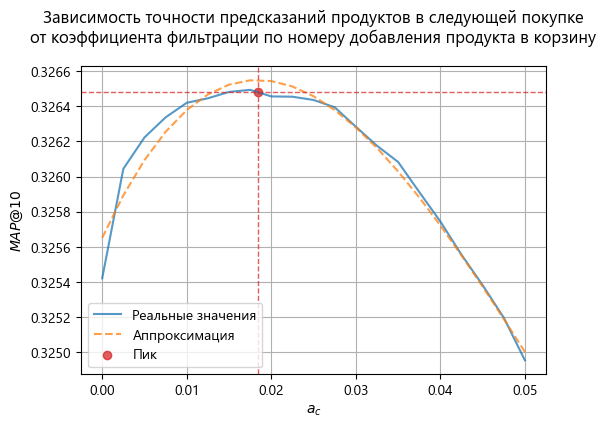

In [27]:
ax = map10_cart.plot( 
    xlabel='$a_с$', ylabel='$MAP@10$',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.set_title('Зависимость точности предсказаний продуктов в следующей покупке\n'
    'от коэффициента фильтрации по номеру добавления продукта в корзину', y=1.05)
ax.plot(map10_cart.index.values, map10_cart_pred, linestyle='--', color='#ff7f0e', alpha=0.75)
ax.scatter(cart_rate, cart_map10, color='#d62728', linewidth=1, alpha=0.75)
ax.axvline(cart_rate, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
ax.axhline(cart_map10, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
_ = ax.legend(['Реальные значения', 'Аппроксимация', 'Пик'])

(0.0, 20.0)

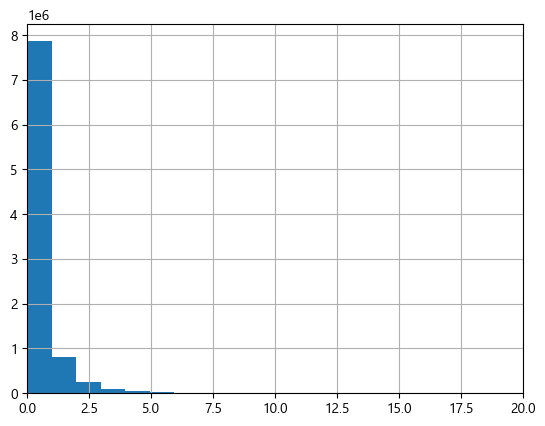

In [28]:
ax = cart_ratings['rating'].hist(bins=int(np.ceil(cart_ratings['rating']).max()))
ax.set_xlim(0, 20)

График показывает, что значение коэффицента $a_c$ влияет на качество фильтрации. Так при **значениях** этого коэффициента **близких к нулю**  (т.е. при слабой фильтрации), как и должно быть, **значение** метрики $MAP@10$ **близко к значению, полученному после применения фильтрации частоте и времени**. Далее по мере роста коэффициентов наблюдается небольшой рост качества фильтрации, который **достигает** своего **пика** при значении коэффициента в районе **0.016...0.02**. При продолжении роста значения коэффициента качество фильтраций начинает быстро снижаться. А при значениях коэффицента **больше 0.045** влияние фильтрации становится **отрицательным** (метрика $MAP@10$ опускается ниже значения, полученного при фильтрации по частоте и времени).

Попробуем более точно определить положение и величину вершины пика этой зависимости. Для этого на отрезке $[0, 0.05]$ аппроксимируем функцию $MAP@10(a_d)$ с помощью полиномиальной функции 3-го порядка. После этого найдем точку на этом отрезке, в которой производная полиномиальной функции равна нулю. Это и будет искомая точка уточненного положения пика - оптимальное значение коэффицента $a_c$. А затем уже в той точке найдем реальное значение метрики $MAP@10$. Это значение будет характеризовать точность предсказаний при использовании фильтрации по номеру добавления продукта в корзину.

In [29]:
md('**Результаты**:<br>'
   'Фильтрация по номеру добавления продукта в корзину дала **небольшой прирост точности** предсказаний '
   f'(метрика $MAP@10$ **выросла** всего на **{(cart_map10 - days_map10):.6f}** с {days_map10:.6f} до {cart_map10:.6f}) '
   f'при значении коэффициента фильтрации $a_с$ равном **{cart_rate:.6f}**.')

**Результаты**:<br>Фильтрация по номеру добавления продукта в корзину дала **небольшой прирост точности** предсказаний (метрика $MAP@10$ **выросла** всего на **0.001062** с 0.325421 до 0.326484) при значении коэффициента фильтрации $a_с$ равном **0.018372**.

#### Фильтрация по популярности продуктов среди всех пользователей 

Для каждого продукта кроме рейтинга у конкретного пользователя можно определить его глобальный рейтинг, представляющий собой среднее значение рейтинга данного продукта среди всех пользователей. Расчёт такого рейтинга производится по формуле:
$$r^g_i={\sum_{u \in U}r_{u,i} \over |U|},$$
где&nbsp;$r^g_i$ - глобальный рейтинг продукта с номером $i$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$U$ - множество номеров пользователей в транзакциях;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_{u,i}$ - рейтинг продукта с номером $i$ у пользователя с номером $u$.

Попробуем проанализировать продукты с каким глобальным рейтингом ошибочно не попали в рекомендации на основе вышеобозначенных фильтраций.

Сначала находим глобальные рейтинги продуктов на основе предыдущих транзакций.

In [30]:
total_ratings = f.get_total_ratings(
    f.get_weights(
        prior_transactions, days_rate=days_rate, cart_rate=cart_rate))\
    .rename(columns={'rating': 'total_rating'})
total_ratings['total_rank'] = total_ratings['total_rating'].rank(ascending=False).astype(int)

Затем находим список последних купленных пользователями продуктов, которые не попали в рекомендации.

In [31]:
prediction = f.get_prediction(
    f.get_ratings(
        f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate)))
missed_last_products = last_transactions\
    .merge(prediction, on=['user_id', 'product_id'], how='left')
missed_last_products = missed_last_products.loc[missed_last_products['rating'].isna()]\
    .reset_index(drop=True).drop(columns='rating')

Добавляем полученную к последним купленным продуктам информацию об их рейтингах.

In [32]:
missed_last_products = missed_last_products\
    .merge(total_ratings[['product_id', 'total_rating', 'total_rank']], on='product_id', how='left')

Далее отображаем распределение глобального ранга среди последних купленных пользователями продуктов, которые не попали в рекомендации.

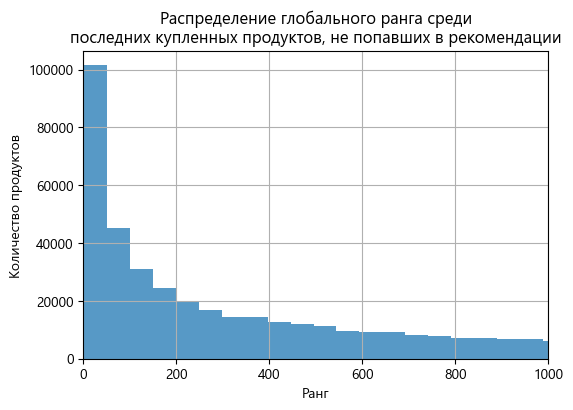

In [33]:
ax = missed_last_products['total_rank'].plot(
    kind='hist', bins=1000,
    title='Распределение глобального ранга среди\n'
    'последних купленных продуктов, не попавших в рекомендации', 
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.set_xlabel('Ранг')
ax.set_ylabel('Количество продуктов')
_ = ax.set_xlim(0, 1000)

Гисторграмма показывает, что в рекомендации чаще всего ошибочно не попадают продукты с высоким глобальным рейтингом. Попробуем учесть это обстоятельство и скорретировать работу модели. Для этого будем повышать рейтинги популярных продуктов (имеющих высокие глобальные рейтинги). Назовем такую корретировку рейтингов "фильтрацией по популярности". Как и раньше построим её на базе экспоненциальной фильтрации. В итоге рейтинг продукта будет рассчитываться по следующей формуле:   
$$r^*_{u,i}=r_{u,i}·e^{r^g_i·a_p},$$
где&nbsp;$r_{u,i}$ - рейтинг продукта с номером $i$ у пользователя с номером $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r^g_i$ - глобальный рейтинг продукта с номером $i$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$a_p$ - коэффициент фильтрации продуктов по популярности.

Для проверки действия фильтрации по популярности и влияния на точность предсказаний значения коэффициента $a_p$ построим график зависимости значения метрики $MAP@10$ от величины этого коэффициента.

In [ ]:
start, stop, num = 0.0, 1.0, 21
map10_total = multiprocessing(start=start, stop=stop, num=num, func='get_map10_by_total_rates', 
                              days_rate=days_rate, cart_rate=cart_rate)

In [ ]:
map10_total_pred, total_rate = f.approximate_precision_by_rate(map10_total.index, map10_total, 3)
total_weights = f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate)
total_ratings = f.get_ratings(total_weights, total_rate=total_rate)
total_prediction = f.get_prediction(total_ratings)
total_map10 = f.get_prediction_precision(last_products, total_prediction)

In [ ]:
ax = map10_total.plot(
    title='Зависимость точности предсказаний набора продуктов в следующей покупке\n'
    'от коэффициента фильтрации по популярности продуктов', 
    xlabel='$a_p$',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.plot(map10_total.index.values, map10_total_pred, linestyle='--', color='#ff7f0e', alpha=0.75)
ax.scatter(total_rate, total_map10, color='#d62728', linewidth=1, alpha=0.75)
ax.axvline(total_rate, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
ax.axhline(total_map10, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
_ = ax.legend(['Реальные значения', 'Аппроксимация', 'Пик'])

График показывает, что значение коэффицента $a_p$ влияет на качество фильтрации. Так при значениях этих коэффициентов близких к нулю  (т.е. при слабой фильтрации), как и должно быть, значение метрики $MAP@10$ близко к значению, полученному на основе фильтрации по времени покупки и порядковому номеру добавления продукта в корзину. Далее по мере роста коэффициента наблюдается небольшой рост увеличения качества фильтрации, который достигает своего **пика** при значении коэффициента в районе **0.3...0.4**. При продолжении роста значения коэффициента качество фильтрации начинает **быстро снижаться**. А при значениях коэффицента **больше 0.8** влияние фильтрации становится **отрицательным** (метрика $MAP@10$ опускается ниже значения, полученного при фильтрации по времени и порядковому номеру добавления продукта в корзину).

Попробуем более точно определить положение и величину вершины пика этой зависимости. Для этого аппроксимируем функцию $MAP@10(a_p)$ на отрезке $[0, 1.0]$ с помощью полиномиальной функции. После этого найдем точку на этом отрезке, в которой производная этой функции равна нулю. Это и будет точка примерного положения пика. А затем в той точке найдем реальное значение метрики $MAP@10$.

In [ ]:
md('**Результаты**:<br>'
   'Фильтрация по популярности продуктов дала **небольшой прирост точности** предсказаний '
   f'(метрика $MAP@10$ **выросла** всего на **{(total_map10 - cart_map10):.6f}** с {cart_map10:.6f} до {total_map10:.6f}) '
   f'при значении коэффициента фильтрации $a_p$ равном **{total_rate:.6f}**.')

#### Заполнение 

В свой модели мы выставляли рейтинги продуктам пользователя, которые он ранее покупал. Но нам требуется предложить пользователю определенное количество продуктов. Вполне возможно, что раньше он покупал меньшее количество уникальных продуктов. В этом случае имеет смысл кроме ранее покупаемых пользователем продуктов, дополнительно предложить ему продукты пользующиеся высоким спросом у других пользователей. При этом логично предположить, что пользователю следует предлагать продукты из тех групп, продукты из которых он ранее активно покупал.

Проверим верно ли наше предположение. Для этого у каждого пользователя определим ранги групп продуктов в соответствии с суммарным рейтингом продуктов, входящих в данную группу:

$$r_{u,a}=\sum_{i \in I_a}r_{u,i},$$
где&nbsp;$r_{u,i}$ - рейтинг продукта с номером $i$ у пользователя с номером $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$I_a$ - номера продуктов в группе продуктов с номером $a$ ($a \in A$, где $A$ - множество номеров групп продуктов, $I_a \in I$, где $I$ - множетство номеров продуктов).

В каждой группе ранжируем продукты на основании их глобальных рейтингов $r^g_i$.

In [ ]:
ratings = f.get_ratings(f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate))
aisle_ranks = f.get_aisle_ranks(ratings, products)
inside_aisle_ranks = f.get_inside_aisle_ranks(ratings, products)

Затем найдем список последних купленных пользователями продуктов, которые ошибочно не попали в рекомендации.

In [ ]:
prediction = f.get_prediction(
    f.get_ratings(f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate), total_rate=total_rate))
missed_last_products = last_transactions\
    .merge(prediction, on=['user_id', 'product_id'], how='left')
missed_last_products = missed_last_products.loc[missed_last_products['rating'].isna()]\
    .reset_index(drop=True).drop(columns='rating')

Далее рассмотрим распределение этих полученных рангов среди последних купленных пользователями продуктов, которые не попали в рекомендации.

In [ ]:
missed_last_products = missed_last_products.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')
missed_last_products = missed_last_products.merge(aisle_ranks, on=['user_id', 'aisle_id'], how='left')
missed_last_products = missed_last_products.merge(inside_aisle_ranks, on=['product_id', 'aisle_id'], how='left')

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
missed_last_products['aisle_rank'].plot(
    ax=ax1, kind='hist', bins=int(missed_last_products['aisle_rank'].max()),
    title='Распределение ранга группы среди\n'
    'последних купленных продуктов, не попавших в рекомендации', 
    grid=True, fontsize=10, legend=False, alpha=0.75)
ax1.set_xlabel('Ранг')
ax1.set_ylabel('Количество продуктов')
_ = ax1.set_xlim(1, 25)
missed_last_products['inside_aisle_rank'].plot(
    ax=ax2, kind='hist', bins=int(missed_last_products['inside_aisle_rank'].max()),
    title='Распределение ранга внутри группы среди\n'
    'последних купленных продуктов, не попавших в рекомендации', 
    grid=True, fontsize=10, legend=False, alpha=0.75)
ax2.set_xlabel('Ранг')
ax2.set_ylabel('Количество продуктов')
_ = ax2.set_xlim(1, 25)

Гистораммы показывают, что предположение имеет право на существование, т.к. значительная часть продуктов ошибочно не попавших в рекомендации относится к группам с высоким рангом и имеют высокий ранг в своих группах.

Проверим какой эффект дает такое заполнение на тренировочных данных.

In [ ]:
prediction = f.get_prediction(
    f.get_ratings(f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate), total_rate=total_rate))
filled_up_prediction = f.fill_up_prediction(prediction, aisle_ranks, inside_aisle_ranks)
filled_up_map10 = f.get_prediction_precision(last_products, filled_up_prediction)

In [ ]:
md('**Результаты**:<br>'
   'Дополнение предсказаний популярными товарами из популярных групп дало **незначительный прирост точности** предсказаний '
   f'(метрика $MAP@10$ **выросла** всего на **{(filled_up_map10 - total_map10):.6f}** с {total_map10:.6f} до {filled_up_map10:.6f}).')

### Тестирование модели рекомендаций

In [ ]:
md(
    'Протестируем работу модели на полном наборе транзакций при поочередном добавлении фильтраций транзакций так же как при обучении. '
    'Сначала найдем точность предсказаний при использовании только фильтрации по частоте. Затем добавим фильтрацию по времени. '
    'Потом дополнительно применим фильтрацию по номеру добавления продукта в корзину. '
    'Далее дополнительно применим фильтрацию по популярности. И на последнем этапе применим заполнение. '
    f'Результуты будем отправлять на проверку на платформу **Kaggle** в виде решения для соревнования "**{COMPETITION}**".'
)

In [ ]:
if not EVAL_PATH.exists():
    EVAL_PATH.mkdir()

In [ ]:
tests = pd.DataFrame(
    [
        ['Фильтрация по частоте', 1, 0, 0, 0, 0], 
        ['Фильтрация по частоте и времени', 1, 1, 0, 0, 0], 
        ['Фильтрация по частоте, времени и номеру добавления продукта в корзину', 1, 1, 1, 0, 0], 
        ['Полный набор фильтраций', 1, 1, 1, 1, 0],
        ['Полный набор фильтраций и заполнение', 1, 1, 1, 1, 1]
    ],
    columns = ['description', 'frequency_filtering', 'days_filtering', 'cart_filtering', 'popularity_filtering', 'filling_up']
)
tests['file_name'] = tests[['frequency_filtering', 'days_filtering', 'cart_filtering', 'popularity_filtering', 'filling_up']]\
    .apply(lambda params: '_'.join([column for param, column in zip(params, params.index) if param]) + '.csv', axis=1)

In [ ]:
transactions = prior_transactions.copy()
transactions['days_before_last_order'] += transactions['days_before_last_order_shift']
transactions = pd.concat([transactions, last_transactions])
for _, (
    days_filtering, cart_filtering, popularity_filtering, filling_up, file_name
) in tests[['days_filtering', 'cart_filtering', 'popularity_filtering', 'filling_up', 'file_name']].iterrows():
    prediction = f.get_prediction(
        f.get_ratings(
            f.get_weights(
                transactions, 
                days_rate=days_rate if days_filtering else 0., 
                cart_rate=cart_rate if cart_filtering else 0.
            ), 
            total_rate=total_rate if popularity_filtering else 0.
        ), 
    )
    if filling_up:
        ratings = f.get_ratings(f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate))
        aisle_ranks = f.get_aisle_ranks(ratings, products)
        inside_aisle_ranks = f.get_inside_aisle_ranks(ratings, products)
        prediction = f.fill_up_prediction(prediction, aisle_ranks, inside_aisle_ranks)
    f.save_kaggle_submission_csv(
        prediction,
        EVAL_PATH / file_name
    )

In [ ]:
kaggle.send_submission_files(EVAL_PATH.as_posix() + '/' + tests['file_name'], tests['description'])
test_results = kaggle.receive_submission_scores(tests['description'])
test_results['meanScore'] = test_results[['publicScore', 'privateScore']].mean(axis=1)
test_results['rank'] = test_results['meanScore'].rank().astype(int)

In [ ]:
test_results['color'] = '#1f77b4'
test_results.at[test_results['meanScore'].idxmax(), 'color'] = '#ff7f0e'
ax = test_results.plot(
    kind='barh', x='description', y='meanScore', color=test_results['color'], 
    title={}, xlabel='',
    figsize=(6, 2), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.set_xlabel('$MAP@10$')
_ = ax.set_xlim(0.27, 0.33)

In [ ]:
test_results.set_index('description')[['publicScore', 'privateScore', 'meanScore']].style.highlight_max(color='#FF9F4A')

In [ ]:
best_map10 = test_results['meanScore'].max()
best_params = test_results.at[test_results['meanScore'].idxmax(), 'description']

In [ ]:
md(
    '**Выводы:**<br>'
    '1. Простая фильтрация по частоте покупок уже обеспечивает требуемую точность предсказаний '
    f'(${test_results.at[0, "meanScore"]:.6f} > 0.25$). '
    f'Остальные типы фильтрации значительно улучшают результат (до ${test_results.at[4, "meanScore"]:.6f}$). '
    f'Основной прирост точности обеспечила фильтрация по времени покупки ($+{(test_results.at[1, "meanScore"] - test_results.at[0, "meanScore"]):.6f}$). '
    f'Ещё немного добавили фильтрации по номеру добавления продукта в корзину и его популярности '
    f'($+{(test_results.at[2, "meanScore"] - test_results.at[1, "meanScore"]):.6f}$ и '
    f'$+{(test_results.at[3, "meanScore"] - test_results.at[2, "meanScore"]):.6f}$ соответственно). '
    f'А вот заполнение внесло несущественный вклад '
    f'$+{(test_results.at[4, "meanScore"] - test_results.at[3, "meanScore"]):.6f}$).<br>'
    f'2. Точность предсказаний модели на тестовых данных (${test_results.at[4, "meanScore"]:.6f}$) '
    f'сопоставима с точностью, показанной при валидации на тренировочных данных (${filled_up_map10:.6f}$). '
    'Это говорит о том, что **алгоритм** модели **вполне рабочий**, а сама **модель хорошо обучена**.'
)

In [ ]:
    for file_name in [
        # 'frequency_ratings.dmp',
        # 'frequency_map_10.dmp',
        # 'days_rate.dmp',
        # 'days_weights.dmp',
        # 'days_ratings.dmp',
        # 'days_map10.dmp',
        # 'map10_days.dmp',
        # 'map10_days_pred.dmp',
        # 'cart_rate.dmp',
        # 'cart_weights.dmp',
        # 'cart_ratings.dmp',
        # 'cart_map10.dmp',
        # 'map10_cart.dmp',
        # 'map10_cart_pred.dmp',
        # 'total_rate.dmp',
        # 'total_weights.dmp',
        # 'total_ratings.dmp',
        # 'total_map10.dmp',
        # 'map10_total.dmp',
        # 'map10_total_pred.dmp',
        # 'missed_last_products.dmp',
        # 'test_results.dmp',
        # 'products_reordering.dmp',
        # 'products_reordering_percentages.dmp',
        'prediction.dmp',
        'filled_up_prediction.dmp',
        'filled_up_map10',
    ]:
        file_path = DATA_PATH / file_name
        with open(file_path, 'wb') as fp:
            dump(globals()[file_path.stem], fp)

In [ ]:
missed_last_products.info()

In [ ]:
missed_last_products = missed_last_products\
    .merge(total_ratings[['product_id', 'total_rating', 'total_rank']], on='product_id', how='left')